In [2]:
import ray

ray.init(ignore_reinit_error=True)

2023-12-19 08:38:03,075	INFO worker.py:1673 -- Started a local Ray instance.


Python version:,3.11.4
Ray version:,2.8.1


In [3]:
ray.__version__


'2.8.1'

In [4]:
from ray import train, tune
from fastcore.xtras import Path


In [5]:
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.algorithm import Algorithm

from ray.tune.logger import pretty_print


2023-12-19 08:38:07,242	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! See https://github.com/ray-project/ray/tree/master/rllib_contrib#rllib-contrib for more information on the RLlib contrib effort.


In [6]:
import torch
import os
# Set device currently does nothing
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

In [7]:
#no GPU support. Still an open issue:
#https://github.com/ray-project/ray/issues/28321
#tune.Tuner(tune.with_resources(0, resources={"cpu": 8, "gpu": 1}),...
#https://docs.ray.io/en/latest/tune/api/doc/ray.tune.with_resources.html
ray.get_gpu_ids()

[]

In [8]:
#grid search parameters
# tune.grid_search([0.01, 0.001])


In [9]:
#custom model example: https://docs.ray.io/en/latest/rllib/rllib-models.html

In [10]:
# agent, model, and environment setup
param_space = (PPOConfig()
            .environment(env="CartPole-v1")
            .framework("torch")
            .training(lr=0.01, model=dict(fcnet_activation='relu')))

# sets save directory and when to end training                        
run_config=train.RunConfig(name="my_tune_run_2",
                           storage_path=str(Path('.').resolve()/'saved_agents'),
                           stop={"episode_reward_mean": 90},
                           checkpoint_config=train.CheckpointConfig(
                                            checkpoint_score_attribute="episode_reward_mean",
                                            checkpoint_score_order="max"
                                                                   ))
#load configs into Tuner
tuner = tune.Tuner("PPO", run_config=run_config,
                   param_space=param_space,
                    )
#training model
results = tuner.fit()


(pid=65995) 2023-12-19 09:05:46,843	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! See https://github.com/ray-project/ray/tree/master/rllib_contrib#rllib-contrib for more information on the RLlib contrib effort.
(RolloutWorker pid=66007) /Users/sbrewer/anaconda3/envs/rllib/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.single_observation_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.single_observation_space` for environment variables or `env.get_wrapper_attr('single_observation_space')` that will search the reminding wrappers.
(Rollout

In [11]:
# Find best model
best_result = results.get_best_result(metric="episode_reward_mean", mode="max")

# Get the best checkpoint corresponding to the best result.
best_checkpoint = best_result.checkpoint


algo = Algorithm.from_checkpoint(best_checkpoint.path)

/Users/sbrewer/anaconda3/envs/rllib/lib/python3.11/site-packages/ray/rllib/algorithms/algorithm.py:484: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/Users/sbrewer/anaconda3/envs/rllib/lib/python3.11/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/Users/sbrewer/anaconda3/envs/rllib/lib/python3.11/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This AP

In [12]:
best_checkpoint.path

'/Users/sbrewer/Documents/NAVAIR/RL_Scripts/saved_agents/my_tune_run_2/PPO_CartPole-v1_b3807_00000_0_2023-12-19_09-05-44/checkpoint_000000'

In [13]:
policy = algo.get_policy()
#print(policy.get_weights())
model = policy.model

In [14]:
model

PPOTorchRLModule(
  (encoder): TorchActorCriticEncoder(
    (actor_encoder): TorchMLPEncoder(
      (net): TorchMLP(
        (mlp): Sequential(
          (0): Linear(in_features=4, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
        )
      )
    )
    (critic_encoder): TorchMLPEncoder(
      (net): TorchMLP(
        (mlp): Sequential(
          (0): Linear(in_features=4, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
        )
      )
    )
  )
  (pi): TorchMLPHead(
    (net): TorchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=2, bias=True)
      )
    )
  )
  (vf): TorchMLPHead(
    (net): TorchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=1, bias=True)
      )
    )
  )
)

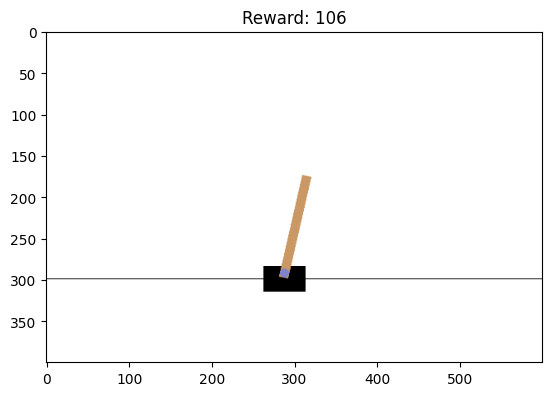

In [15]:
# render agent
import gymnasium as gym
import matplotlib.pyplot as plt
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

N=50
env_name = "CartPole-v1"
env = gym.make(env_name, render_mode="rgb_array")

reward_lst=[]
for n in range(N):
    episode_reward = 0
    obs, info = env.reset()

    while True:

        action = algo.compute_single_action(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_reward += reward
        if n ==N-1:
            clear_output(wait=True)
            plt.imshow( env.render())
            plt.title(f'Reward: {int(episode_reward)}')
            plt.show()

        if done or episode_reward>500:
            reward_lst.append(episode_reward)
            break

env.close()

In [16]:
import pandas as pd
pd.Series(reward_lst).describe()

count     50.000000
mean     184.240000
std       78.743852
min       89.000000
25%      131.500000
50%      169.500000
75%      211.500000
max      498.000000
dtype: float64

In [ ]:
list(gym.envs.registry.keys())

In [ ]:
import datetime as dt
end=dt.datetime.now()
print(f'Finished: {end.strftime("%A %B %d, %Y")} at {end.strftime("%H:%M")}')